In [78]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from orbax.checkpoint import (CheckpointManager,
                              PyTreeCheckpointer)

sns.set_theme(context="paper",
              font_scale=1.25,
              style="ticks",
              palette="colorblind")

In [84]:
# ckpt_path = "outputs/train-reservoir/2024-01-18/21-56-07/checkpoints/"
ckpt_path = "outputs/train-reservoir/2024-01-18/22-42-35/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
ckpt = mgr.restore(mgr.latest_step())

In [85]:
targets = jnp.concatenate([jnp.reshape(x, (-1, x.shape[-1]))
                           for x in ckpt["metrics_history"]["train"]["target"]], axis=0)
outputs = jnp.concatenate([jnp.reshape(x, (-1, x.shape[-1]))
                           for x in ckpt["metrics_history"]["train"]["output"]], axis=0)

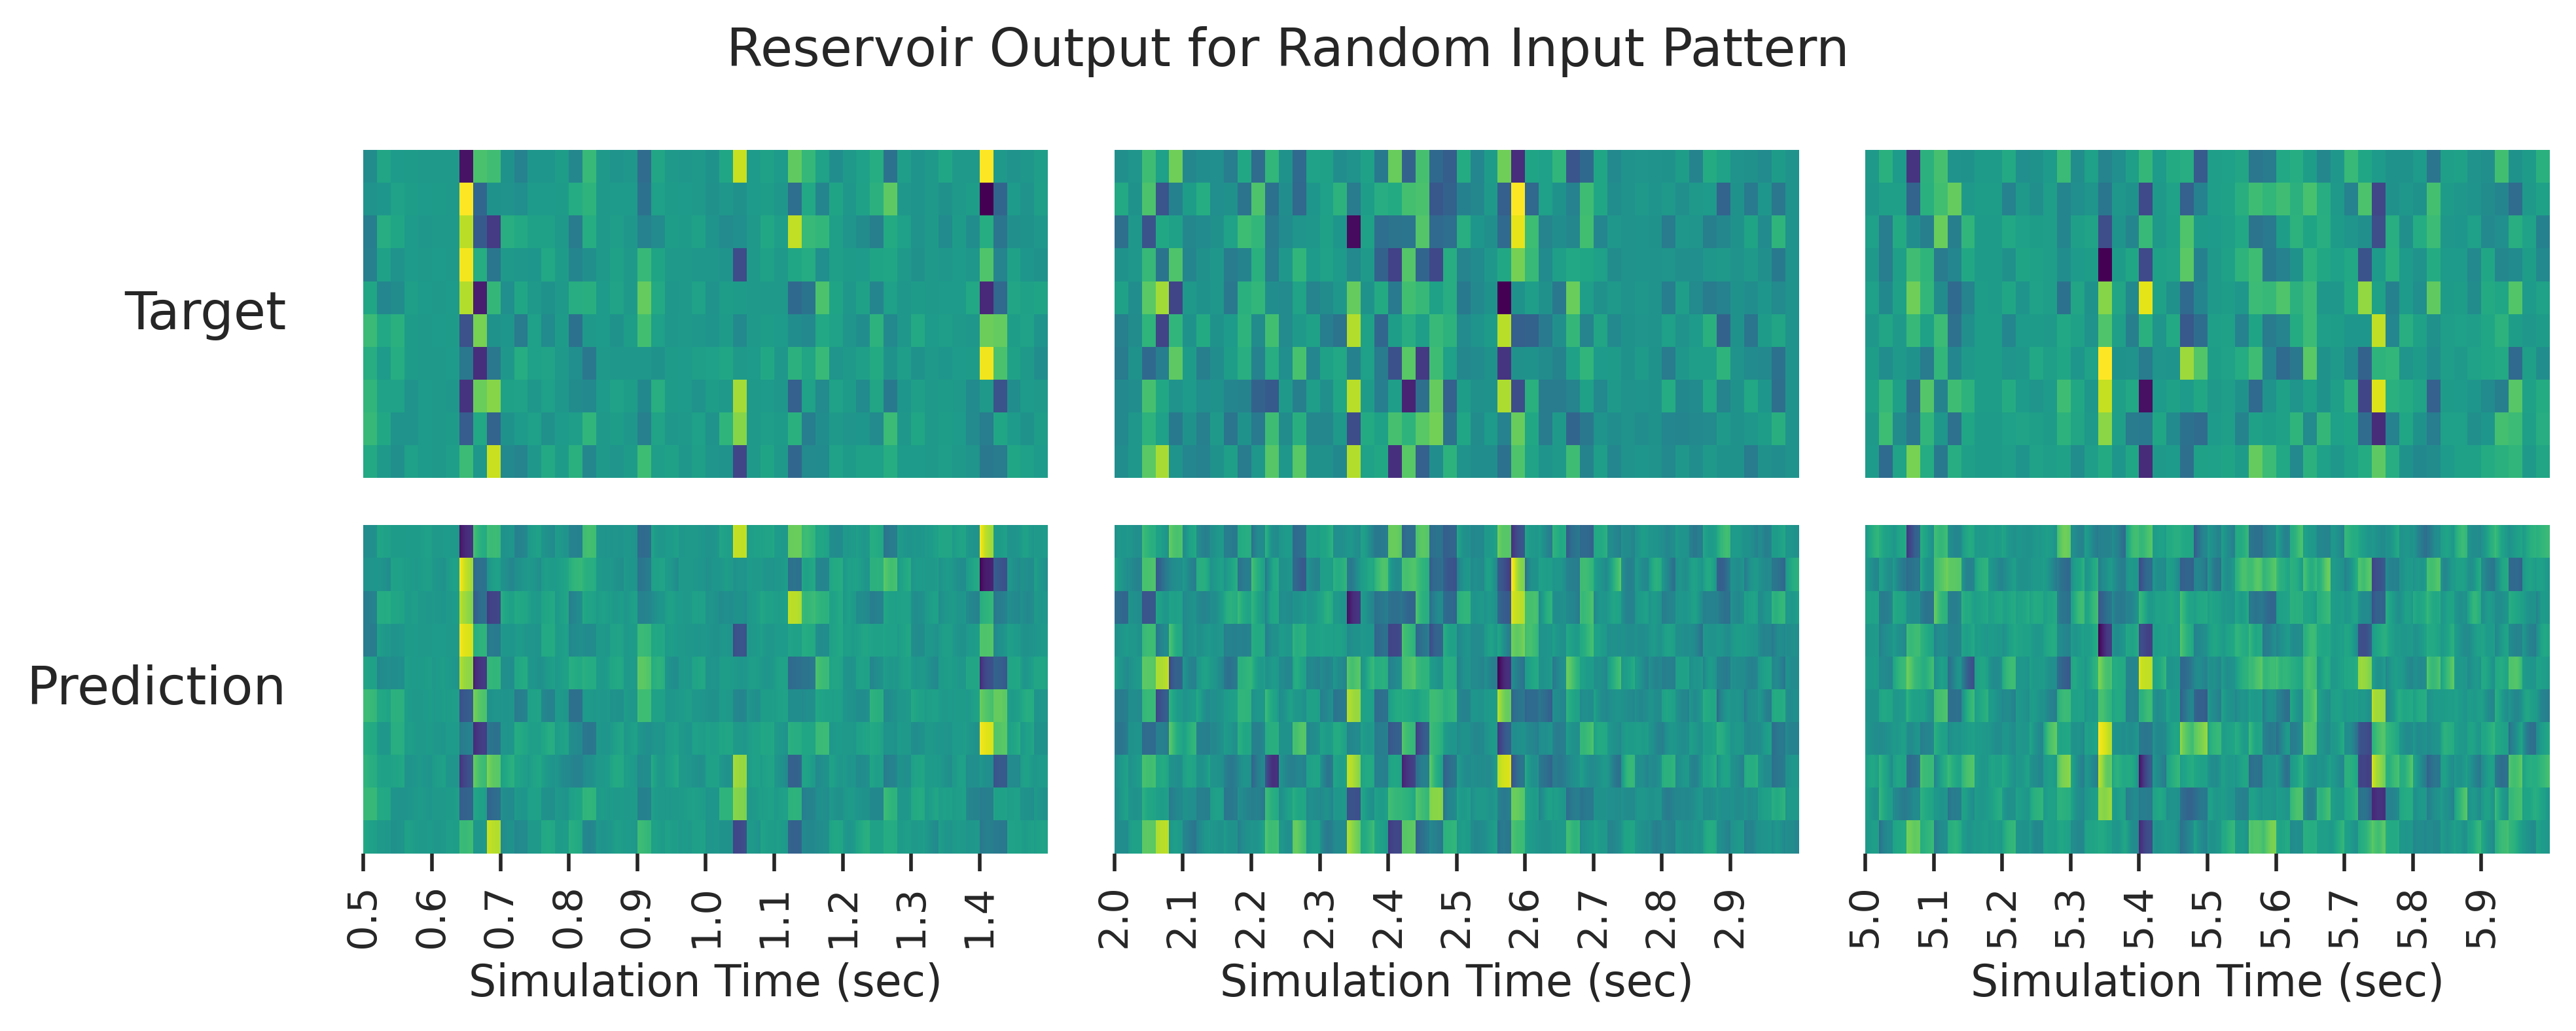

In [106]:
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=400, figsize=(10, 4),
                        subplot_kw={"sharex": True, "sharey": True})

t = jnp.arange(targets.shape[0]) * 1e-3
for i, (tmin, tmax) in enumerate([(500, 1500), (2000, 3000), (5000, 6000)]):
    sns.heatmap(jnp.transpose(targets[tmin:tmax]),
                cbar=False, cmap="viridis", ax=axs[0, i])
    axs[0, i].set_xticklabels([])
    axs[0, i].set_yticklabels([])
    axs[0, i].tick_params(left=False, bottom=False)
    sns.heatmap(jnp.transpose(outputs[tmin:tmax]),
                cbar=False, cmap="viridis", ax=axs[1, i])
    axs[1, i].set_yticklabels([])
    axs[1, i].tick_params(left=False)
    axs[1, i].set_xticks(jnp.arange(0, tmax - tmin, 100),
                    map(lambda x: ("%.1f" % x), t[tmin:tmax:100]))
    axs[1, i].set_xlabel("Simulation Time (sec)")
axs[0, 0].annotate("Target",
                    xy=(0, 0.5),
                    xytext=(-axs[0, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[0, 0].yaxis.label,
                    textcoords='offset points',
                    size="large",
                    ha='right',
                    va='center')
axs[1, 0].annotate("Prediction",
                    xy=(0, 0.5),
                    xytext=(-axs[1, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[1, 0].yaxis.label,
                    textcoords='offset points',
                    size="large",
                    ha='right',
                    va='center')
fig.suptitle("Reservoir Output for Random Input Pattern")
fig.tight_layout()
fig.savefig("reservoir-output.pdf")

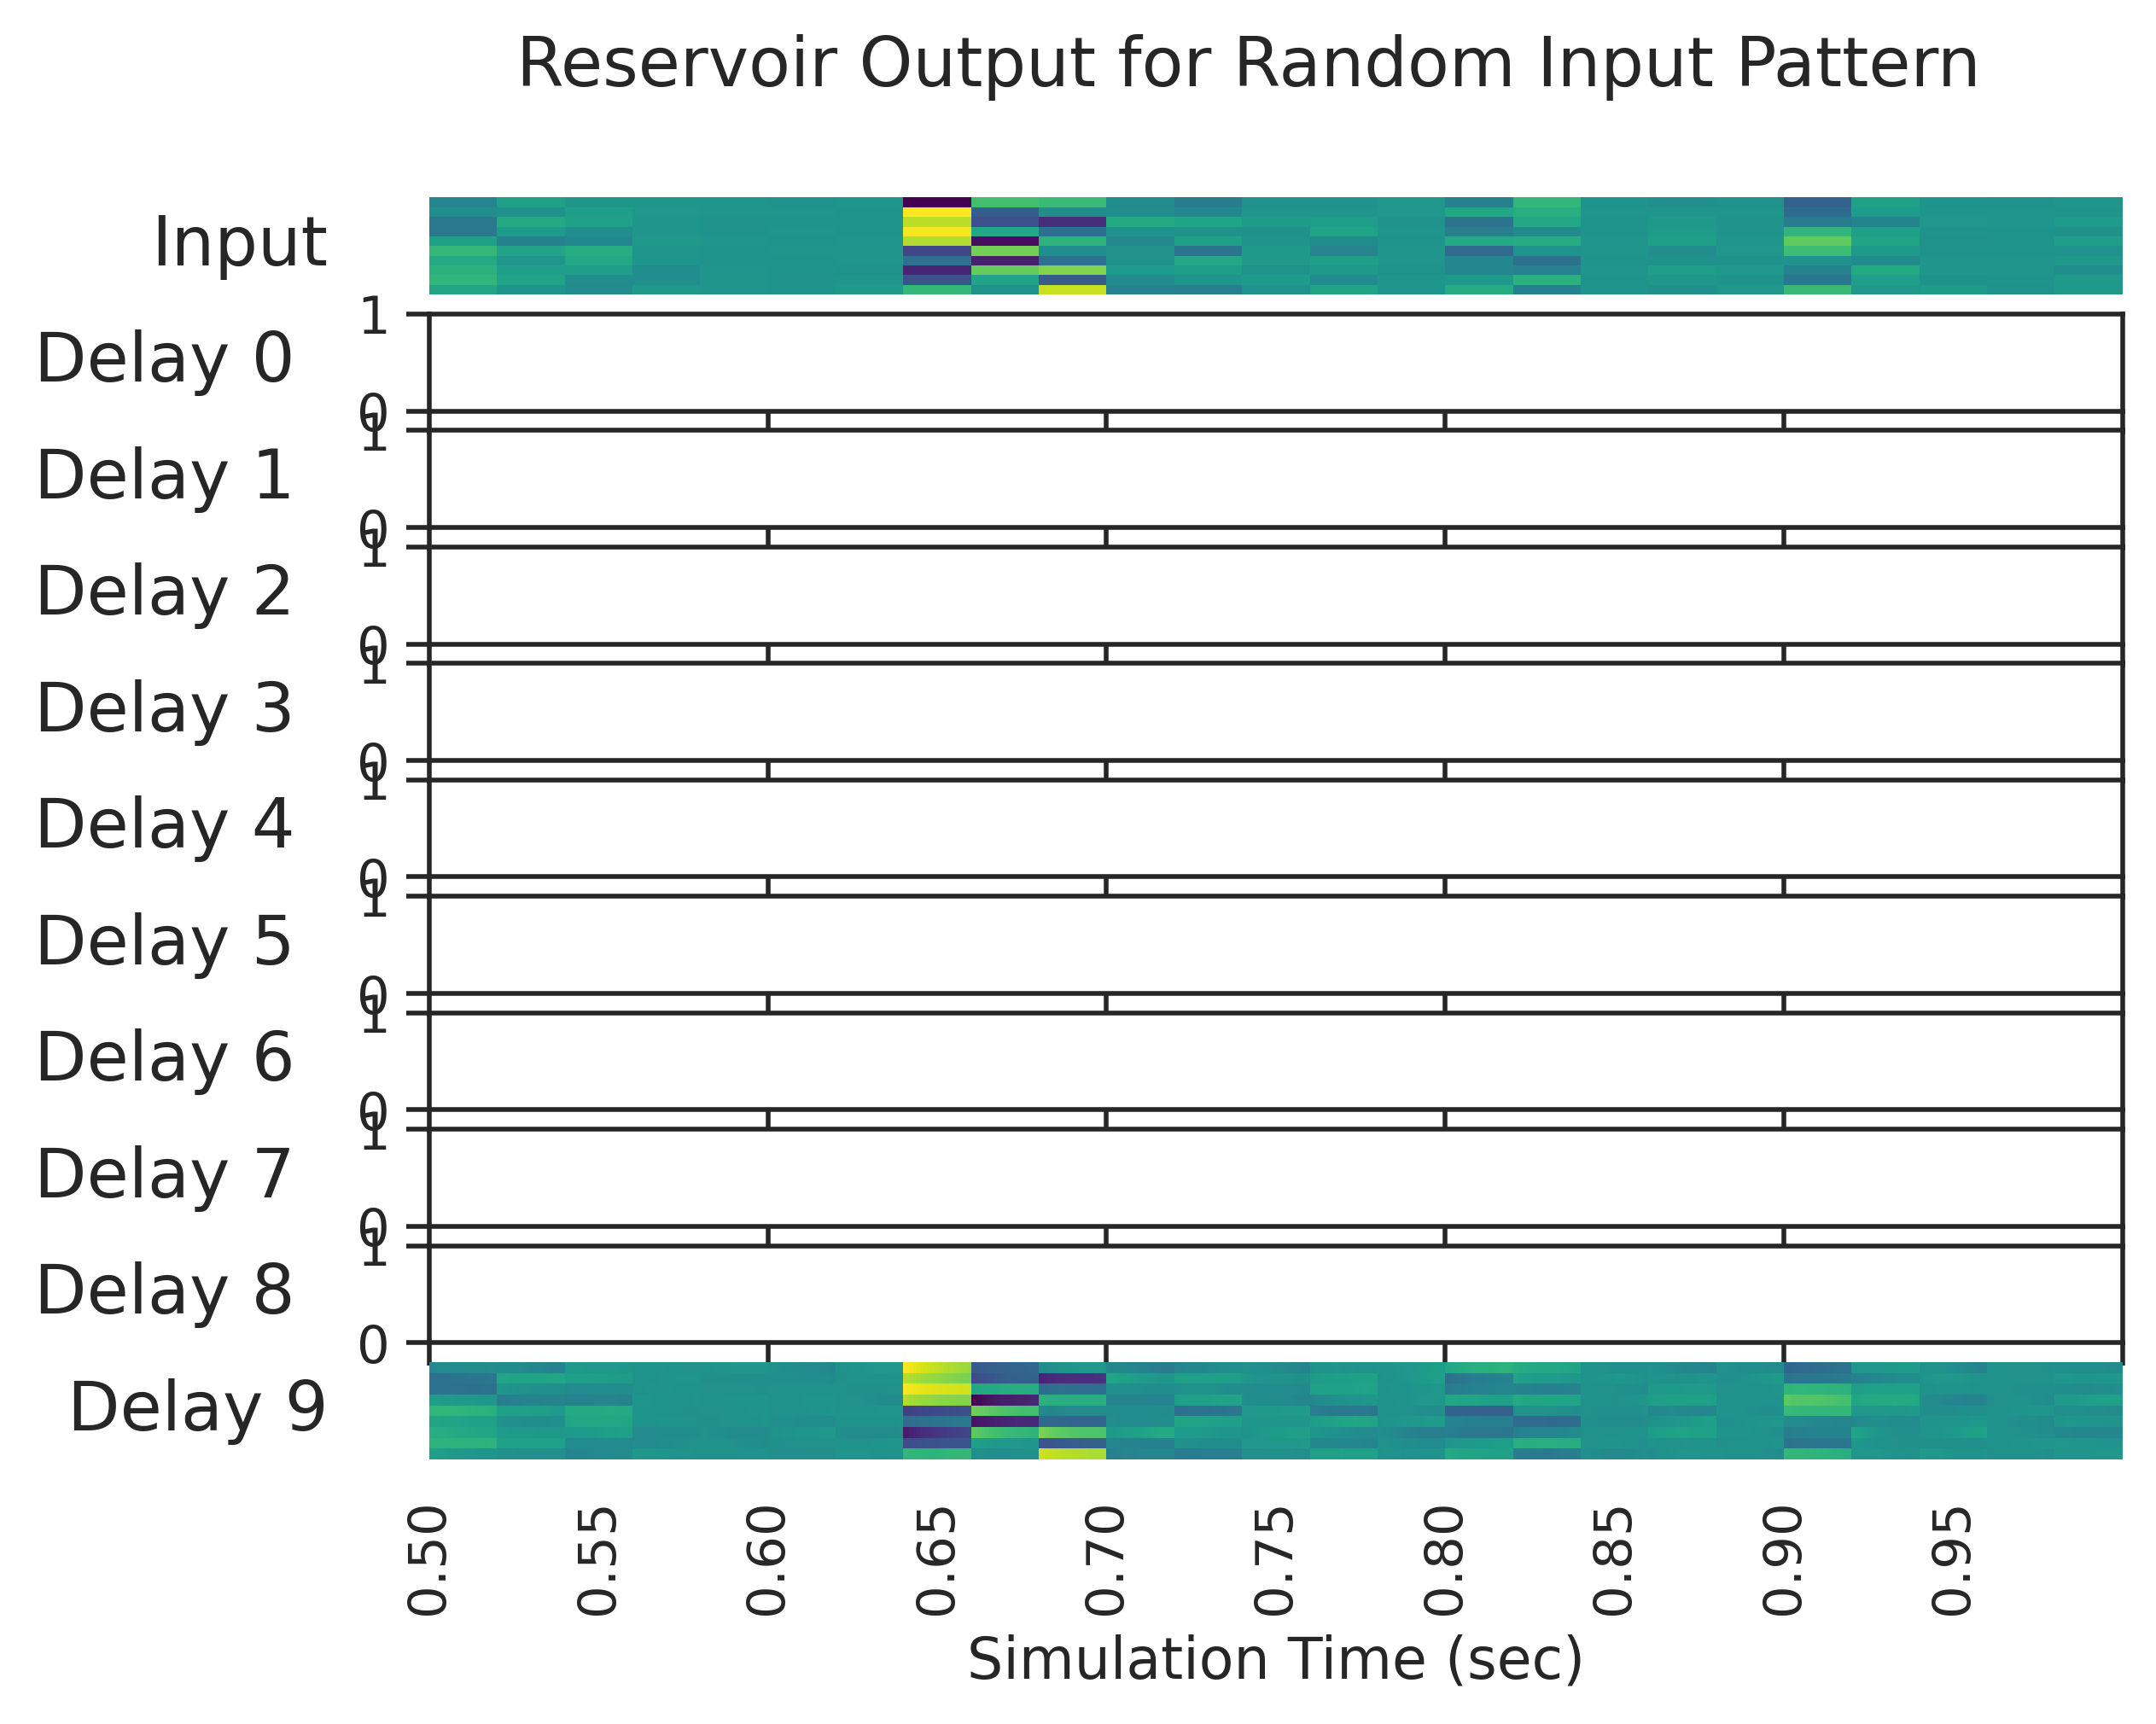

In [89]:
fig, axs = plt.subplots(nrows=11, dpi=400,
                        subplot_kw={"sharex": True, "sharey": True})

d = 50 + 1 + 10
t = jnp.arange(targets.shape[0]) * 1e-3
sns.heatmap(jnp.transpose(targets[500:1000, -d:]),
                cbar=False, cmap="viridis", ax=axs[0])
axs[0].set_yticklabels([])
axs[0].tick_params(left=False, bottom=False)
for i in range(1, targets.shape[1], d):
    ax = axs[10 - i // d]
    sns.heatmap(jnp.transpose(outputs[500:1000, i:(i + d)]),
                cbar=False, cmap="viridis", ax=ax)
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=False)
for ax in axs[:-1]:
    ax.set_xticklabels([])
axs[-1].set_xticks(jnp.arange(0, 500, 50),
                   map(lambda x: ("%.2f" % x), t[500:1000:50]))
axs[-1].set_xlabel("Simulation Time (sec)")
for i, ax in enumerate(axs[1:]):
    ax.annotate(f"Delay {i}",
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label,
                textcoords='offset points',
                size="large",
                ha='right',
                va='center')
axs[0].annotate("Input",
                xy=(0, 0.5),
                xytext=(-axs[0].yaxis.labelpad - 5, 0),
                xycoords=axs[0].yaxis.label,
                textcoords='offset points',
                size="large",
                ha='right',
                va='center')
fig.suptitle("Reservoir Output for Random Input Pattern")
fig.savefig("resevoir-output.pdf", dpi=400)

<Axes: >

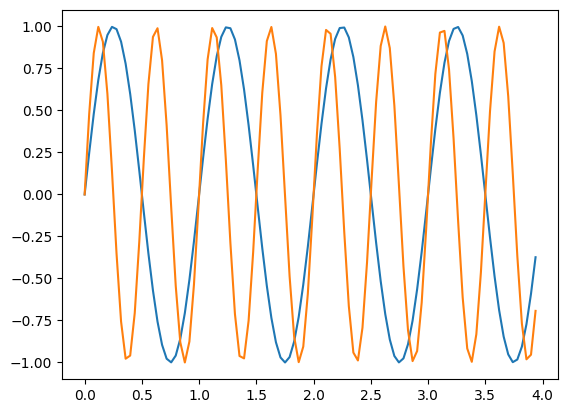

In [36]:
f = 2 * jnp.pi * jnp.arange(1, 3)
t = jnp.arange(100) / (2 * f[-1])
xdata = jnp.sin(jnp.expand_dims(f, axis=0) * jnp.expand_dims(t, axis=1))

fig, ax = plt.subplots()

sns.lineplot(x=t, y=xdata[:, 0], ax=ax)
sns.lineplot(x=t, y=xdata[:, 1], ax=ax)

In [45]:
jnp.reshape(xdata, -1)

Array([ 0.        ,  0.        ,  0.24740396,  0.47942555,  0.47942555,
        0.841471  ,  0.6816387 ,  0.997495  ,  0.841471  ,  0.90929747,
        0.9489846 ,  0.5984722 ,  0.997495  ,  0.14112024,  0.98398596,
       -0.35078323,  0.90929747, -0.7568025 ,  0.7780732 , -0.9775301 ,
        0.5984722 , -0.9589243 ,  0.381661  , -0.70554036,  0.14112024,
       -0.27941597, -0.1081949 ,  0.21511953, -0.35078323,  0.6569866 ,
       -0.5715613 ,  0.93799996, -0.7568025 ,  0.98935825, -0.8949894 ,
        0.7984871 , -0.9775301 ,  0.4121185 , -0.9992928 , -0.07515112,
       -0.9589243 , -0.54402107, -0.8589345 , -0.8796958 , -0.70554036,
       -0.9999902 , -0.5082791 , -0.8754522 , -0.27941597, -0.5365737 ,
       -0.03317922, -0.06632189,  0.21511953,  0.42016616,  0.4500445 ,
        0.803785  ,  0.6569866 ,  0.9906074 ,  0.8230809 ,  0.93489504,
        0.93799996,  0.65028787,  0.9945988 ,  0.20646748,  0.98935825,
       -0.28790334,  0.9226042 , -0.7117853 ,  0.7984871 , -0.96

In [46]:
xdata[:, 0]

Array([ 0.        ,  0.24740396,  0.47942555,  0.6816387 ,  0.841471  ,
        0.9489846 ,  0.997495  ,  0.98398596,  0.90929747,  0.7780732 ,
        0.5984722 ,  0.381661  ,  0.14112024, -0.1081949 , -0.35078323,
       -0.5715613 , -0.7568025 , -0.8949894 , -0.9775301 , -0.9992928 ,
       -0.9589243 , -0.8589345 , -0.70554036, -0.5082791 , -0.27941597,
       -0.03317922,  0.21511953,  0.4500445 ,  0.6569866 ,  0.8230809 ,
        0.93799996,  0.9945988 ,  0.98935825,  0.9226042 ,  0.7984871 ,
        0.624724  ,  0.4121185 ,  0.17388947, -0.07515112, -0.3195192 ,
       -0.54402107, -0.7346985 , -0.8796958 , -0.9699979 , -0.9999902 ,
       -0.967808  , -0.8754522 , -0.728665  , -0.5365737 , -0.31111935,
       -0.06632189,  0.18259819,  0.42016616,  0.6316103 ,  0.803785  ,
        0.9259825 ,  0.9906074 ,  0.9936411 ,  0.93489504,  0.8180218 ,
        0.65028787,  0.44212216,  0.20646748, -0.04202435, -0.28790334,
       -0.51588184, -0.7117853 , -0.8634335 , -0.96139747, -0.99